# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [1]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import numpy.ma as ma
from multiprocessing import Pool
from scipy.optimize import minimize
from biokey.data import DataInterface
import biokey.tools
from biokey.tools import parallel_process
import json
import random
# This makes plots render inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
% matplotlib inline

In [3]:
data = DataInterface(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Loaded dwell and flight from cache
Done Loading



In [4]:
key_press_count = data.get_dwells().key.value_counts()
mask = list(string.ascii_uppercase)
mask.extend(['ESCAPE', 'ENTER', 'SPACE', 'CONTROL', 'META', 'BACKSPACE', 'SHIFT'])

In [5]:
datasets = data.get_all_sets()
# for u in datasets:
#     datasets[u] = biokey.tools.filter_sets(datasets[u], to_include=mask)

# Building Profile Using Threshold

In [6]:
from scipy.stats import ttest_ind_from_stats

class Node(object):
    def __init__(self, name):
        self.name = name
        self.children = {}
        self.stats = None
        self.parent = None
    def add(self, hash1):
        self.children[hash1.name] = hash1
        self.parent = self
        return hash1
    def goto(self, name):
        if(name in self.children):
            return self.children[name]

class Profile(object):
    def __init__(self, df, threshold, trim=None):
        self.trimmed = trim
        self.threshold = threshold
        if data is not None and threshold is not None:
            self._build_profile(df, threshold)
            if trim:
                self.profile = self.profile.loc[self.profile['count'] >= trim]
                self._build_tree()
    
    def _build_profile(self, df, t):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = None
        seqs = []
        count = -1
        for row in df.itertuples():
            count += 1
            row = {
                'key': row.key,
                'down': row.down,
                'up': row.up,
                'interval': row.interval,
                'count': count
            }
            if start == None:
                # First after threshold
                start = row
            else:
                # Nth after threshold - queue as starters
                inner_queue.append(row)
            # Add it to the chain
            chain.append(str(row['key']))
            seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
            # If threshold is not met then start again
            if row['interval'] > t:
                for i in range(len(inner_queue)):
                    start = inner_queue[i]
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(row['key']))
                        seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
                chain = []
                inner_queue = []
                start = None
        # Aggregate sequences
        self.seqs = pd.DataFrame(seqs)
        s = self.seqs.copy()
        s.loc[:,'log_duration'] = np.log(s.duration)
        seq_dur = s.groupby('seq').aggregate(['mean', 'std', 'count']).log_duration
        # Fill missing values with a proxy
        seq_dur['std'] = seq_dur['std'].fillna((seq_dur['std']/seq_dur['mean']).mean()*seq_dur['mean'])
        self.profile = seq_dur
        self._build_tree()
    
    def update_profile(self, df):
        self.profile = df
        self._build_tree()
    
    def diversify(self, other_profile):
        compared_profiles = pd.merge(self.profile, other_profile.profile, left_index=True, right_index=True)
        compared_profiles['pvalue'] = compared_profiles.apply((lambda x: ttest_ind_from_stats(x.mean_x, x.std_x, x.count_x, x.mean_y, x.std_y, x.count_y, False).pvalue), axis=1)
        new_profile = compared_profiles.loc[compared_profiles.pvalue < 0.05,['mean_x', 'std_x', 'count_x']]
        new_profile.columns = ['mean', 'std', 'count']
        self.update_profile(new_profile)
        
    def _build_tree(self):
        self.root = Node('root')
        for s, row in self.profile.iterrows():
            n = self.root
            for k in s.split('-'):
                new = n.goto(k)
                if not new:
                    new = n.add(Node(k))
                n = new
            n.stats = row.to_dict()
            
    def trim(self, n):
        "Returns a new profile, trimmed to sequences with n instances"
        new_p = Profile(None, self.threshold, n)
        new_p.profile = self.profile.loc[self.profile['count'] >= n]
        new_p.seqs = self.profile.loc[self.seqs.seq.isin(self.profile.index)]
        new_p._build_tree()
        return new_p
    
    def search_tree(self, path):
        "Search tree for the node at a given list path"
        n = self.root
        for p in path:
            new = n.goto(p)
            if not new:
                return None
            n = new
        return n
    
    def features(self):
        return np.array(self.profile.index)

    def test_distance(self, path, duration):
        "Returns the probability that a typed path's duration was the profiles's"
        node = self.search_tree(path)
        if node is None or node.stats is None:
            return -1
        stats = node.stats
        return np.exp(-np.square((np.log(duration)-stats['mean']))/(2*np.square(stats['std'])))
        
    def test_window(self, df):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = -1
        instances = {}
        results = {}
        
        for f in self.features():
            instances[f] = []
            results[f] = 0
        for row in df.itertuples():
            if start == -1:
                start = row.down
            else:
                inner_queue.append(row)
            chain.append(str(row.key))
            seq = '-'.join(chain)
            if seq in instances:
                instances[seq].append(self.test_distance(chain, row.up - start))
            if row.interval > self.threshold:
                for i in range(len(inner_queue)):
                    start = inner_queue[i].down
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(r.key))
                        seq = '-'.join(chain)
                        if seq in instances:
                            instances[seq].append(self.test_distance(chain, r.up - start))
                chain = []
                inner_queue = []
                start = -1
                
        for f in instances:
            durations = instances[f]
            if len(durations) > 0:
                results[f] = np.mean(durations)
        return pd.Series(results)

In [7]:
userid_valid = data.get_users()[2]
train = datasets[userid_valid].train
test = datasets[userid_valid].test

train_valid = train.loc[train.is_user]
train_imposter = train.loc[train.is_user == False]

test_valid = test.loc[test.is_user]
test_imposter = test.loc[test.is_user == False]

# user_threshold = optimals[userid_valid]
seq_cutoff_threshold = 150
seq_occurance_threshold = 30

In [8]:
p = Profile(train_valid, seq_cutoff_threshold, trim=seq_occurance_threshold)

## Build Frames

In [9]:
def test_window_indexes(seqs, profile, start, end):
    s = seqs.loc[(seqs.start >= start) & (seqs.end < end)].copy()
    s['score'] = s.apply((lambda x: profile.test_distance(x.seq.split('-'), x.duration)), axis=1)
    s = s.loc[s.score >= 0]
    results = s.groupby('seq').score.aggregate(['mean', 'count']).T.to_dict()
    '''
    for f in profile.features():
        if f not in results:
            results[f] = {'count': 0, 'mean': 0}
    '''
    return pd.DataFrame(results).T

### Train Frames

In [9]:
seqs_all = Profile(train, seq_cutoff_threshold).seqs

buffer_length = 40
y_vals = list(train.is_user)

def test_iter(i):
    return {
        'x': test_window_indexes(seqs_all, p, i, i + buffer_length).T.to_dict(),
        'y': y_vals[i+buffer_length],
        'i': i
    }

# This takes a bit
# frames = parallel_process(range(buffer_length, len(y_vals)), test_iter, front_num=1, n_jobs=36)
# with open('windowed_frames.json', 'w') as fout:
#     json.dump([f for f in frames if type(f) is not ValueError and type(f) is not IndexError and 'i' in f], fout)

### Test Frames

In [10]:
seqs_all_test = Profile(test, seq_cutoff_threshold).seqs

buffer_length = 40
y_vals_test = list(test.is_user)

def test_iter_test(i):
    return {
        'x': test_window_indexes(seqs_all_test, p, i, i + buffer_length).T.to_dict(),
        'y': y_vals[i+buffer_length],
        'i': i
    }

# test_frames = parallel_process(range(buffer_length, len(y_vals_test)), test_iter_test, front_num=1, n_jobs=16)
# with open('windowed_frames_test.json', 'w') as fout:
#     json.dump([f for f in test_frames if type(f) is not ValueError and type(f) is not IndexError and 'i' in f], fout)

## Load Frames

In [11]:
frames = json.load(open('windowed_frames.json'))
test_frames = json.load(open('windowed_frames_test.json'))

## Test Raw Gaussian Profile

In [55]:
def split_windows(df, window_size):
    arr = [df.loc[i-window_size:i] for i in tnrange(df.is_user.count())]
    X = parallel_process(arr, p.test_window, front_num=0)
    Y = df.is_user.astype('int16')
    return np.array(X), np.array(Y).reshape(Y.count(),1)

# seq_length = 100
# x_train, y_train = split_windows(train.head(30000), seq_length)
# x_test, y_test = split_windows(test.head(30000), seq_length)

In [58]:
x = x_test.copy()
x[x == 0] = np.nan

scores = []
for window in x:
    scores.append(np.nanmean(window))
scores = np.array(scores)

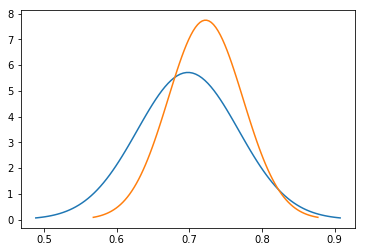

In [59]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

stats = pd.DataFrame({'result': scores, 'is_user': y_test.flatten()}).groupby('is_user').aggregate(['mean', 'std', 'count'])

mu = stats.loc[0]['result']['mean']
sigma = stats.loc[0]['result']['std']

mu1 = stats.loc[1]['result']['mean']
sigma1 = stats.loc[1]['result']['std']

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))

x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
plt.plot(x1,mlab.normpdf(x1, mu1, sigma1))

plt.show()

In [60]:
ttest_ind_from_stats(
    stats.loc[0]['result']['mean'], stats.loc[0]['result']['std'], stats.loc[0]['result']['count'],
    stats.loc[1]['result']['mean'], stats.loc[1]['result']['std'], stats.loc[1]['result']['count'],
False).pvalue

6.554494403177562e-250

In [63]:
stats

result                 
             mean       std  count
is_user                           
0        0.698224  0.069787  19715
1        0.722471  0.051484  10285

In [61]:
pred = pd.DataFrame({'result': scores, 'is_user': y_test.flatten()}).dropna()

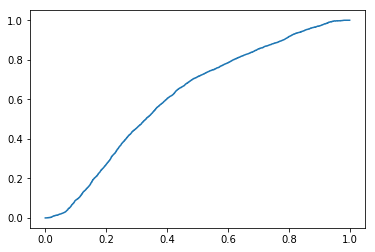

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(pred.is_user,  pred.result)
auc = metrics.roc_auc_score(pred.is_user, pred.result)
plt.plot(fpr,tpr,label="LSTM, auc="+str(auc))

# Build LSTM Model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [13]:
input_features = len(p.features())
input_feature_dimensions = 2 # score, count
lookback_window = 30

num_samples = len(frames) - lookback_window

input_shape = (lookback_window, input_feature_dimensions*input_features)

num_layers = 2
layer_size = 64

batch_size = 32

output_shape = (1)

epochs = 10

In [14]:
features = p.features()
feature_indexes = {}
for i in range(len(features)):
    feature_indexes[features[i]] = i

In [15]:
def parse_frame(f, feature_indexes):
    y = int(f['y'])
    x = np.zeros((len(feature_indexes), 2))
    for s in f['x']:
        i = feature_indexes[s]
        x[i][0] = f['x'][s]['mean']
        x[i][1] = f['x'][s]['count']
    return x, y

In [16]:
def create_window(frames, feature_indexes, start, lookback):
    x_vals = []
    y = None
    for i in range(lookback):
        x, y = parse_frame(frames[start+i], feature_indexes)
        x_vals.append(x)
    return np.array(x_vals).reshape((lookback, len(feature_indexes)*2)), y

In [17]:
def gen_window(frames, feature_indexes, lookback, batch_size=32):
    """
    Generator to yield inputs and their labels in batches.
    """
    batch_x = []
    batch_y = []
    for i in range(batch_size):
        x, y = create_window(frames, feature_indexes, i, lookback)
        batch_x.append(x)
        batch_y.append(y)
    i = batch_size
    while True:
        batch_x = batch_x[1:]
        batch_y = batch_y[1:]
        x, y = create_window(frames, feature_indexes, i, lookback)
        batch_x.append(x)
        batch_y.append(y)
        i = (i + batch_size) % num_samples
        yield np.array(batch_x), np.array(batch_y)

def gen_rand_window(frames, feature_indexes, lookback, batch_size=32):
    """
    Generator to yield inputs and their labels in batches.
    """
    while True:
        batch_x = []
        batch_y = []
        for i in range(batch_size):
            x, y = create_window(frames, feature_indexes, random.randint(0, len(frames)-lookback-1), lookback)
            batch_x.append(x)
            batch_y.append(y)
        yield np.array(batch_x), np.array(batch_y)

def gen_window_default(frames):
    return gen_rand_window(frames, feature_indexes, lookback_window, batch_size)

In [52]:
# create model
lstm_model = Sequential()
# add layers
lstm_model.add(CuDNNLSTM(32, input_shape=input_shape, return_sequences=True))
lstm_model.add(Dropout(0.5))
# lstm_model.add(CuDNNLSTM(int(layer_size/2), return_sequences=True))
# lstm_model.add(Dropout(0.5))
lstm_model.add(CuDNNLSTM(8))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(output_shape, activation='sigmoid'))
# compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
# !rm -R ./Graph/Gaussian_LSTM*/*
# !rm -R ./gaussian-lstm-models/*

In [57]:
run_name = str(datetime.now()).replace(':','.').replace('.','_')
filepath="./gaussian-lstm-models/%s-weights-{epoch:02d}-{val_loss:.2f}.hdf5" % run_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tbCallBack = TensorBoard(log_dir='./Graph/Gaussian_LSTM_%s/' % run_name, histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]

lstm_model.fit_generator(gen_window_default(frames), validation_data=gen_window_default(test_frames), validation_steps=500, epochs=10, steps_per_epoch=2000, callbacks=callbacks_list)

Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2018 - acc: 0.9345
Epoch 00001: val_loss improved from inf to 1.23826, saving model to ./gaussian-lstm-models/2018-03-05 17_19_51_282662-weights-01-1.24.hdf5
2000/2000 [==============================] - 75s 38ms/step - loss: 0.2018 - acc: 0.9346 - val_loss: 1.2383 - val_acc: 0.6677
Epoch 2/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.1573 - acc: 0.9510
Epoch 00002: val_loss did not improve
2000/2000 [==============================] - 73s 36ms/step - loss: 0.1573 - acc: 0.9510 - val_loss: 1.3333 - val_acc: 0.6758
Epoch 3/10
1998/2000 [============================>.] - ETA: 0s - loss: 0.1272 - acc: 0.9624
Epoch 00003: val_loss did not improve
2000/2000 [==============================] - 73s 36ms/step - loss: 0.1271 - acc: 0.9624 - val_loss: 1.4762 - val_acc: 0.6734
Epoch 4/10
1998/2000 [============================>.] - ETA: 0s - loss: 0.1045 - acc: 0.9690
Epoch 00004: val_loss did not improve


## Test It

In [24]:
def far(y_true, y_pred, thresh=0.5):
    total_false = np.equal(y_true, 0).astype('int32').sum()
    false_accepts = (np.equal(y_true, 0) & np.greater_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_accepts/total_false

def frr(y_true, y_pred, thresh=0.5):
    total_accept = np.equal(y_true, 1).astype('int32').sum()
    false_rejects = (np.equal(y_true, 1) & np.less_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_rejects/total_accept

In [26]:
def evaluate(x, y, model, model_path='LSTM Model', index=0, plot=True):
    y_pred = model.predict(x)

    fpr, tpr, thresholds = metrics.roc_curve(y,  y_pred)
    auc = metrics.roc_auc_score(y, y_pred)
    plt.plot(fpr,tpr,label="LSTM"+str(index)+", auc="+str(auc))

    false_accepts = far(y.flatten(), y_pred.flatten())
    false_rejects = frr(y.flatten(), y_pred.flatten())
    accuracy = metrics.accuracy_score(y.flatten(), np.round(y_pred.flatten()))
    print('Model: %s (FAR: %4f FRR: %4f ACC: %4f)' % (model_path, false_accepts, false_rejects, accuracy))
    
    if plot:
        plt.legend(loc=4)
        plt.show()

def evaluate_many(x_data, y_data, model_paths):
    index = 0
    for m in model_paths:
        lstm_model.load_weights(m)
        evaluate(x_data, y_data, lstm_model, m, index=index, plot=False)
        index = index + 1
    plt.legend(loc=4)
    plt.show()

In [29]:
x_train, y_train = next(gen_rand_window(frames, feature_indexes, lookback_window, 2000))
x_test, y_test = next(gen_rand_window(test_frames, feature_indexes, lookback_window, 2000))

In [38]:
y_test.mean()

0.256

Model: LSTM Model (FAR: 0.002614 FRR: 0.036170 ACC: 0.989500)


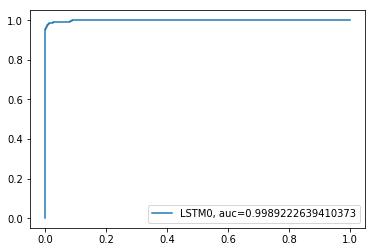

In [30]:
evaluate(x_train, y_train, lstm_model)

Model: LSTM Model (FAR: 0.193548 FRR: 0.703125 ACC: 0.676000)


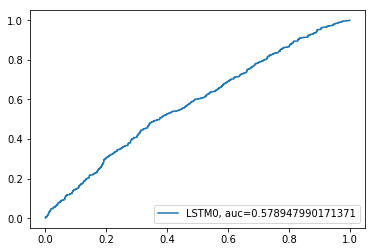

In [31]:
evaluate(x_test, y_test, lstm_model)

Model: ./gaussian-lstm-models/weights-improvement-25-0.98.hdf5 (FAR: 0.203950 FRR: 0.104623 ACC: 0.861880)
Model: ./gaussian-lstm-models/weights-improvement-21-0.98.hdf5 (FAR: 0.240541 FRR: 0.094393 ACC: 0.856320)
Model: ./gaussian-lstm-models/weights-improvement-20-0.98.hdf5 (FAR: 0.244989 FRR: 0.092492 ACC: 0.856080)
Model: ./gaussian-lstm-models/weights-improvement-18-0.98.hdf5 (FAR: 0.244692 FRR: 0.093307 ACC: 0.855640)
Model: ./gaussian-lstm-models/weights-improvement-17-0.98.hdf5 (FAR: 0.198968 FRR: 0.106434 ACC: 0.862360)
Model: ./gaussian-lstm-models/weights-improvement-15-0.98.hdf5 (FAR: 0.267406 FRR: 0.090832 ACC: 0.849620)


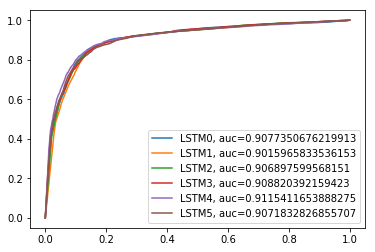

In [113]:
evaluate_many(x_test, y_test, [
    './gaussian-lstm-models/weights-improvement-25-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-21-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-20-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-18-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-17-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-15-0.98.hdf5'
])s

Model: ./gaussian-lstm-models/weights-improvement-20-0.98.hdf5 (FAR: 0.244989 FRR: 0.092492 ACC: 0.856080)
Model: ./gaussian-lstm-models/weights-improvement-03-0.94.hdf5 (FAR: 0.451844 FRR: 0.054409 ACC: 0.811560)
Model: ./gaussian-lstm-models/weights-improvement-05-0.96.hdf5 (FAR: 0.189183 FRR: 0.130062 ACC: 0.850000)
Model: ./gaussian-lstm-models/weights-improvement-21-0.98.hdf5 (FAR: 0.240541 FRR: 0.094393 ACC: 0.856320)
Model: ./gaussian-lstm-models/weights-improvement-09-0.97.hdf5 (FAR: 0.232001 FRR: 0.103356 ACC: 0.853260)
Model: ./gaussian-lstm-models/weights-improvement-18-0.98.hdf5 (FAR: 0.244692 FRR: 0.093307 ACC: 0.855640)
Model: ./gaussian-lstm-models/weights-improvement-25-0.98.hdf5 (FAR: 0.203950 FRR: 0.104623 ACC: 0.861880)
Model: ./gaussian-lstm-models/weights-improvement-01-0.81.hdf5 (FAR: 0.436900 FRR: 0.049369 ACC: 0.819940)
Model: ./gaussian-lstm-models/weights-improvement-13-0.98.hdf5 (FAR: 0.213616 FRR: 0.110719 ACC: 0.854580)
Model: ./gaussian-lstm-models/weights

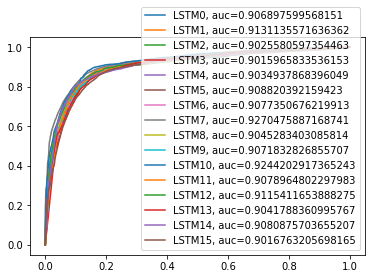

In [117]:
import glob
import os

evaluate_many(x_test, y_test,[f for f in glob.glob(os.path.join('./gaussian-lstm-models/', '*.hdf5'))])

In [101]:
pd.DataFrame({'actual': y.flatten(), 'predicted': y_pred.flatten()}).to_csv('acutal_predicted_output.csv')